# ChatGPT usage in PubMed abstracts via excess vocabulary usage

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import pandas as pd
import pickle

plt.style.use('mpl_style.txt')

In [2]:
words, years, counts, totals = pickle.load(open('../results/yearly-counts.pkl', 'rb'))

freqs = (counts + 1) / (totals + 1)

counts.shape

(4119741, 15)

In [3]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
assert(len(alphabet) == 26)

allowedWords =  np.array([np.all([s in alphabet for s in w]) for w in words])
allowedWords &= np.array([len(w) >= 4 for w in words])

np.sum(allowedWords)

2388676

In [4]:
print(words[allowedWords][np.argmax(freqs[allowedWords, -1])])
print(f'{np.max(freqs[allowedWords, -1]):.3f}')

with
0.845


[[10423 11625 13440 14679 15825 17162 18068 19401 21335 23576 27903 33534
  37938 37581 15611]]
[[16192 16776 17749 18271 18683 19472 19915 20870 21728 22741 23689 25120
  27761 28267 31726]]


<IPython.core.display.Javascript object>


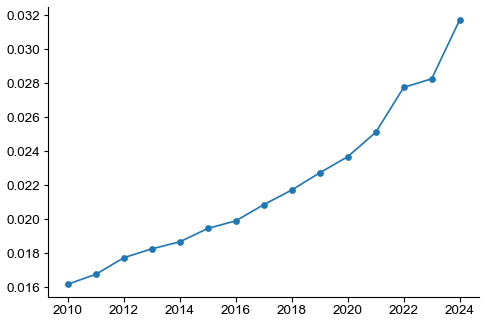

In [5]:
word = 'traditional'

print(counts[words==word].astype(int))
print((freqs[words==word] * 1_000_000).astype(int))

plt.figure(figsize=(3, 2))
plt.plot(years, freqs[words==word].ravel(), '.-')

<IPython.core.display.Javascript object>


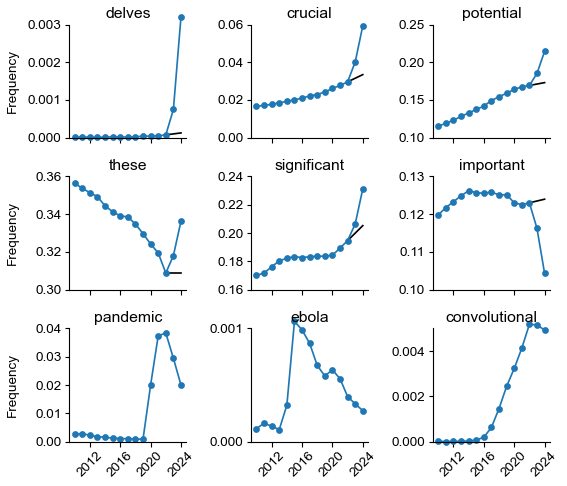

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3.5, 3), layout='constrained')

for num, word in enumerate([
    'delves', 'crucial', 'potential', 'these', 'significant', 
    'important', 'pandemic', 'ebola', 'convolutional'
]):
    freq = freqs[words == word].ravel()
    axs.flat[num].plot(years, freq, '.-', clip_on=False)
    axs.flat[num].set_title(word)
    if num < 6:
        axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
        axs.flat[num].set_xticklabels([])
    else:
        axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
        axs.flat[num].set_xticklabels([2012, 2016, 2020, 2024], rotation=45)
    if num in [0, 3, 6]:
        axs.flat[num].set_ylabel('Frequency')
    if num < 6:
        proj = freq[-3] + np.maximum(0, (freq[-3] - freq[-4])) * 2
        axs.flat[num].plot([2022, 2024], [freq[-3], proj], 'k-', zorder=0)
        
    axs.flat[num].spines[['right', 'top']].set_visible(False)
    
fig.align_ylabels()

axs.flat[0].set_ylim([0, 0.003])
axs.flat[1].set_ylim([0, 0.06])
axs.flat[2].set_ylim([0.1, 0.25])
axs.flat[3].set_ylim([0.30, 0.36])
axs.flat[4].set_ylim([0.16, 0.24])
axs.flat[5].set_ylim([0.1, 0.13])
axs.flat[6].set_ylim([0, 0.04])
axs.flat[7].set_ylim([0, 0.001])
axs.flat[7].set_yticks([0, 0.001])
axs.flat[8].set_ylim([0, 0.005])

plt.savefig('../figures/examples.png', dpi=300)
plt.savefig('../figures/examples.pdf')

In [7]:
def compute_excess(targetYear):
    subsetWords = allowedWords & (
        freqs[:, years == targetYear].ravel() >= 1e-4
    ) & (
        freqs[:, years == targetYear - 1].ravel() >= 1e-4
    )

    projection = freqs[subsetWords, years == targetYear - 2] + np.maximum(
        (
            freqs[subsetWords, years == targetYear - 2] - 
            freqs[subsetWords, years == targetYear - 3]
        ) * 2,
        0
    )
    
    ratios = freqs[subsetWords, years == targetYear] / projection
    diffs  = freqs[subsetWords, years == targetYear] - projection
    x = freqs[subsetWords][:, years == targetYear].ravel()
    
    return subsetWords, ratios, diffs, x

Analyzed words: 26120, increased frequency: 9995


<IPython.core.display.Javascript object>


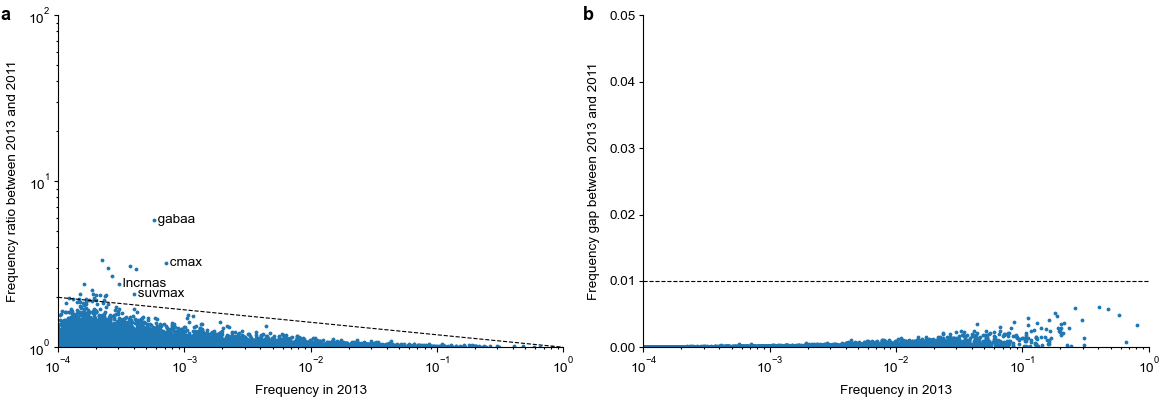

Analyzed words: 26271, increased frequency: 10002


<IPython.core.display.Javascript object>


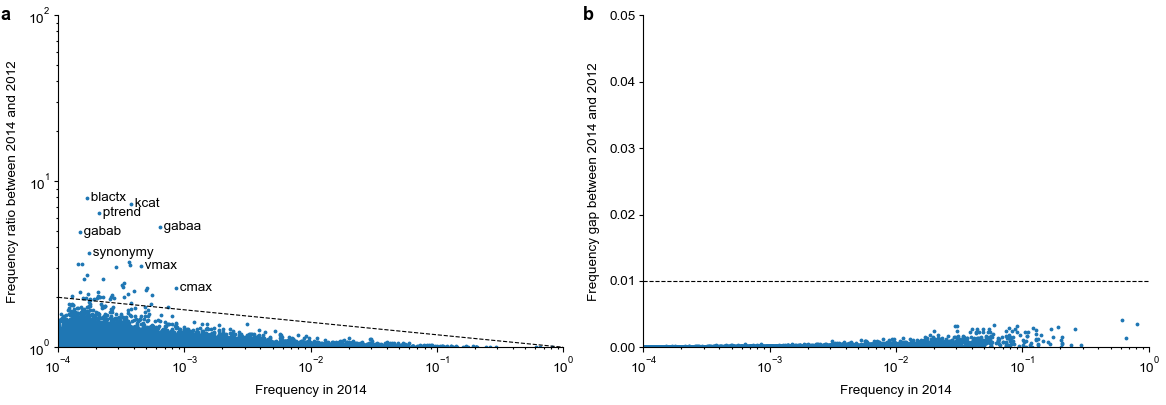

Analyzed words: 26292, increased frequency: 8812


<IPython.core.display.Javascript object>


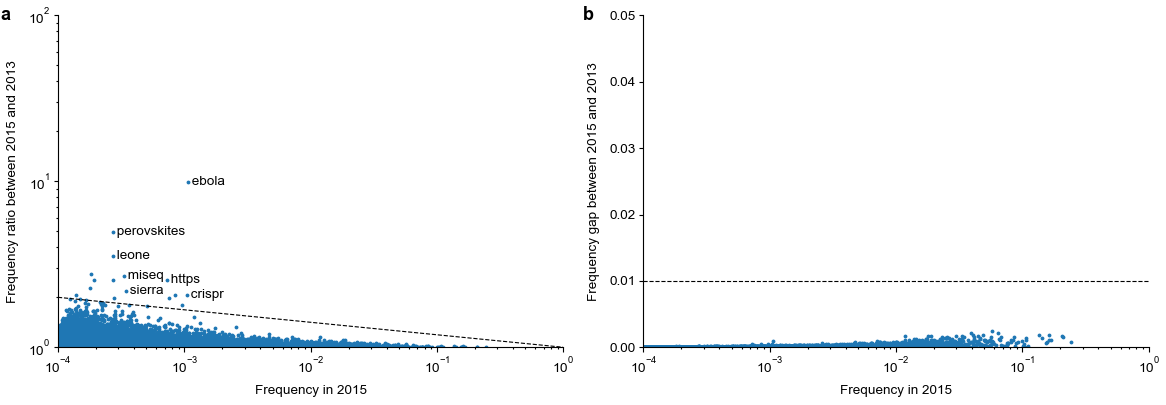

Analyzed words: 26363, increased frequency: 9464


<IPython.core.display.Javascript object>


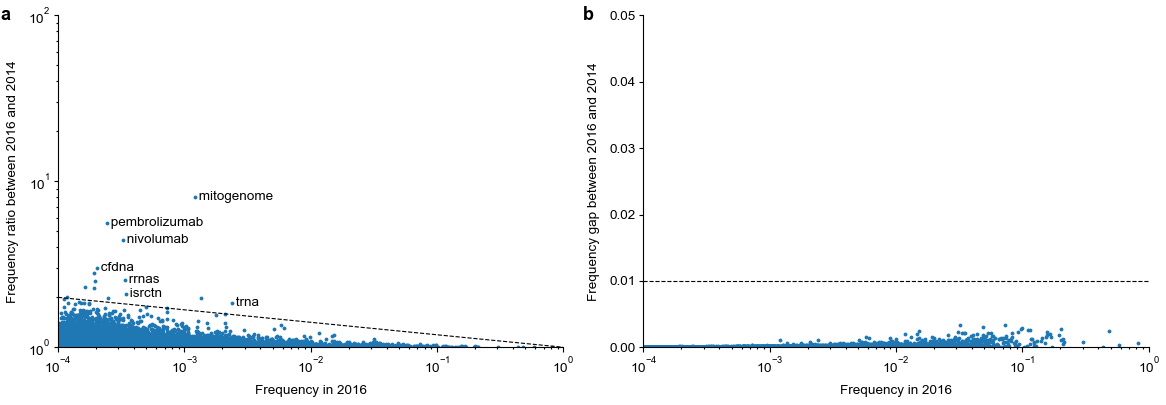

Analyzed words: 26538, increased frequency: 10569


<IPython.core.display.Javascript object>


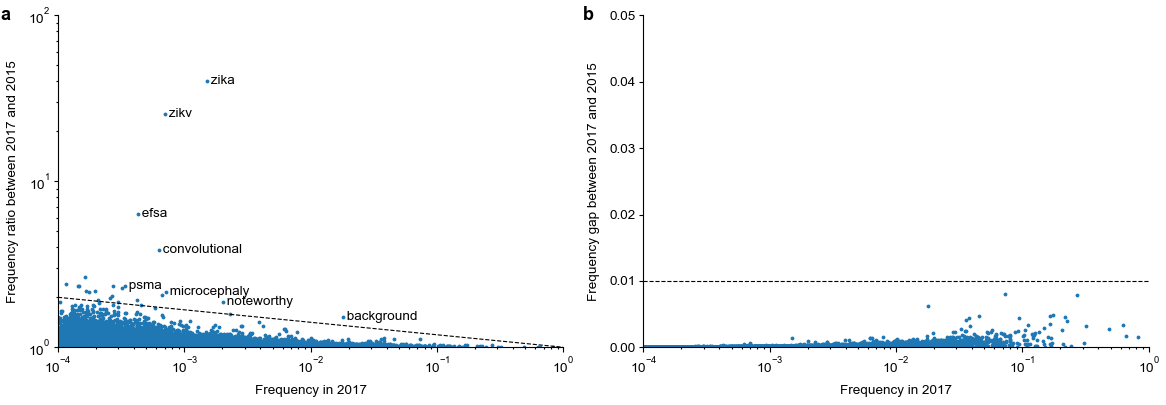

Analyzed words: 26571, increased frequency: 10082


<IPython.core.display.Javascript object>


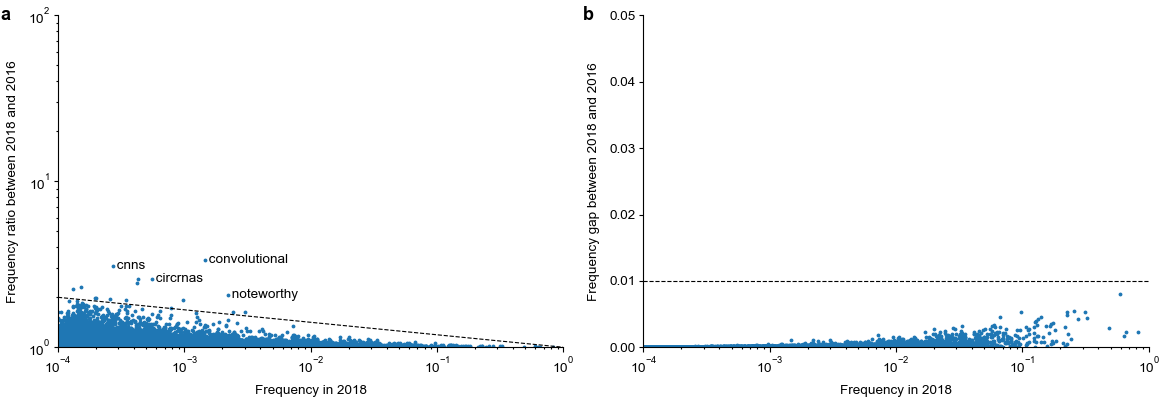

Analyzed words: 26656, increased frequency: 9420


<IPython.core.display.Javascript object>


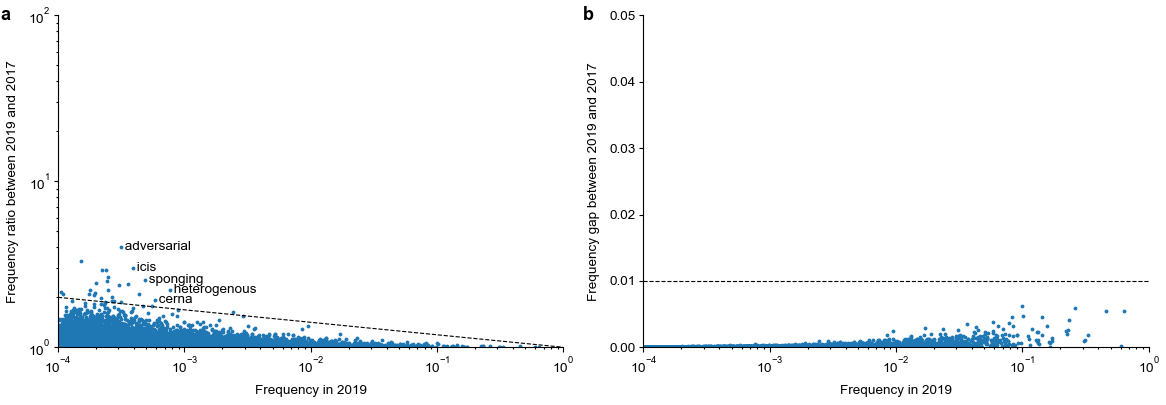

Analyzed words: 26655, increased frequency: 8758


<IPython.core.display.Javascript object>


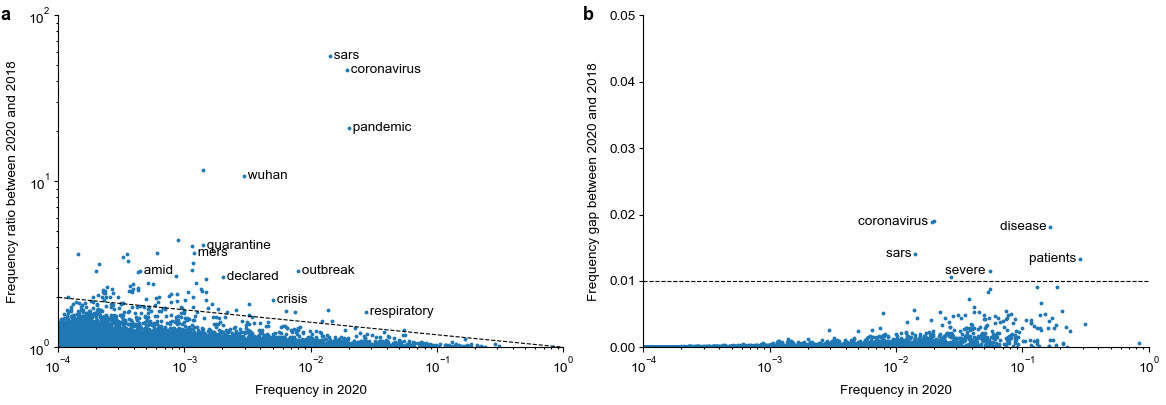

Analyzed words: 26626, increased frequency: 9110


<IPython.core.display.Javascript object>


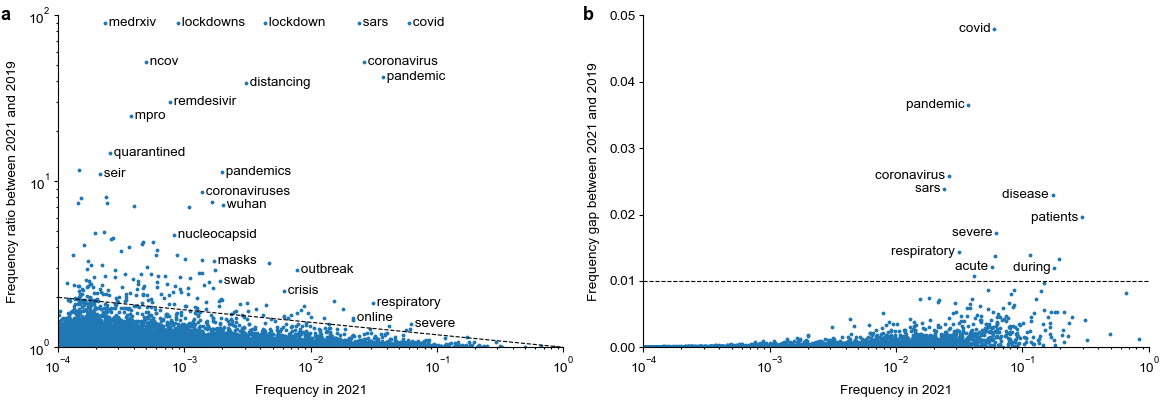

Analyzed words: 26661, increased frequency: 8832


<IPython.core.display.Javascript object>


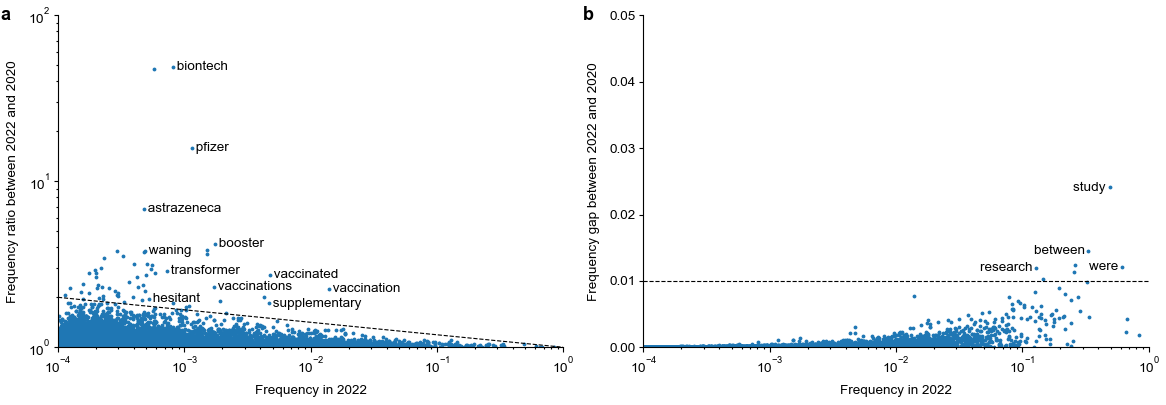

Analyzed words: 26749, increased frequency: 9854


<IPython.core.display.Javascript object>


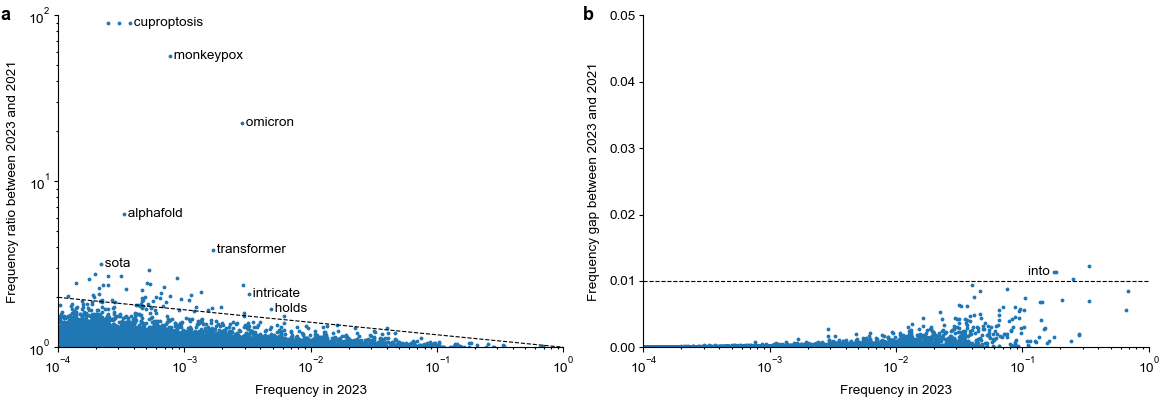

Analyzed words: 26565, increased frequency: 10872


<IPython.core.display.Javascript object>


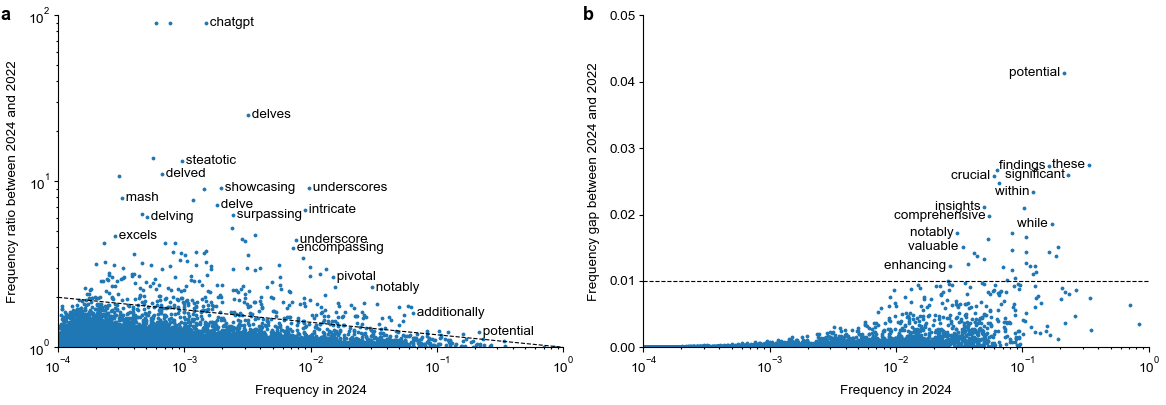

In [8]:
def yearplot(targetYear):
    subsetWords, ratios, diffs, x = compute_excess(targetYear)
    
    print(f'Analyzed words: {ratios.size}, increased frequency: {np.sum(ratios > 1)}')
    
    ratios[ratios > 90] = 90
    diffs[diffs > 0.048] = 0.048
    
    fig = plt.figure(figsize=(7.2, 2.5), layout='constrained')
    plt.subplot(121)
    plt.scatter(x[ratios > 1], ratios[ratios > 1], s=2, rasterized=True)
    plt.ylim([1, 100])
    plt.xlim([1e-4, 1])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(f'Frequency in {targetYear}')
    plt.ylabel(f'Frequency ratio between {targetYear} and {targetYear - 2}')
    plt.plot([1e-4, 1], [2, 1], 'k--', linewidth=.5)
    
    txts_a = []
    txts_points_a = []
    show_labels = np.log10(ratios) > np.log10(2.2) - (np.log10(x) + 4) * (np.log10(2) / 4)
    ind_show_labels = np.where(show_labels)[0]
#     reorder = np.argsort(x[ind_show_labels])[::-1]
#     ind_show_labels = ind_show_labels[reorder]
    for i in ind_show_labels:
        txt = plt.text(x[i], ratios[i], ' ' + words[subsetWords][i], fontsize=6, va='center')
#                       bbox = dict(facecolor='none', edgecolor='k', boxstyle='square,pad=0'))
        txts_a.append(txt)
        txt = plt.text(x[i], ratios[i], ' ', fontsize=6, va='center')
#                       bbox = dict(facecolor='none', edgecolor='r', boxstyle='square,pad=0'))
        txts_points_a.append(txt)
        
    plt.gca().spines[['right', 'top']].set_visible(False)

    plt.subplot(122)
    plt.scatter(x[diffs > 0], diffs[diffs > 0], s=2, rasterized=True)
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.xlim([1e-4, 1])
    plt.xscale('log')
    plt.ylim([0, 0.05])
    plt.plot([1e-4, 1], [0.01, 0.01], 'k--', linewidth=.5)
    plt.xlabel(f'Frequency in {targetYear}')
    plt.ylabel(f'Frequency gap between {targetYear} and {targetYear - 2}')
    
    fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
    fig.text(.5, .95, 'b', fontsize=8, fontweight='bold')
    
    txts_b = []
    txts_points_b = []
    for i in np.where(diffs > 0.011)[0]:
        txt = plt.text(x[i], diffs[i], words[subsetWords][i] + ' ', fontsize=6, ha='right', va='center')
        txts_b.append(txt)
        txt = plt.text(x[i], diffs[i], ' ', fontsize=6, ha='right', va='center')
        txts_points_b.append(txt)
    
    fig.canvas.draw()

    def cleanup_labels(txts, txts_points, ha='left'):
        removed = np.zeros(len(txts), dtype=bool)
        bbox = txts_points[0].get_window_extent()
        space_width = bbox.x1 - bbox.x0
        for i in range(len(txts)):
            bbox = txts[i].get_window_extent()
            if ha == 'left':
                bbox.x0 += space_width
            else:
                bbox.x1 -= space_width
            for j in range(len(txts)):
                if j != i:
                    bbox_point = txts_points[j].get_window_extent()
                    bbox_point.y0 += (bbox_point.y1 - bbox_point.y0) / 3
                    bbox_point.y1 -= (bbox_point.y1 - bbox_point.y0) / 3
                    if bbox.overlaps(bbox_point):
                        removed[i] = True
                        txts[i].remove()
                        break

#         for txt in txts_points:
#             txt.remove()

#         for i in range(len(txts)):
#             if not removed[i]:
#                 for j in range(i):
#                     if not removed[j]:
#                         if txts[i].get_window_extent().overlaps(txts[j].get_window_extent()):
#                             removed[i] = True
#                             txts[i].remove()
#                             break   
        
    if len(txts_a) > 0:
        cleanup_labels(txts_a, txts_points_a)
    if len(txts_b) > 0:
        cleanup_labels(txts_b, txts_points_b, ha='right')


for targetYear in range(2013, 2025):
    yearplot(targetYear)
        
    plt.savefig(f'../figures/words{targetYear}.png', dpi=300)
    plt.savefig(f'../figures/words{targetYear}.pdf', dpi=300)

In [9]:
subsetWords, ratios, diffs, _ = compute_excess(2024)

for word in ['delves', 'showcasing', 'underscores', 'potential', 'findings', 'crucial']:
    print(
        f'{word:15}: {ratios[words[subsetWords] == word][0]:5.2f},'
        f' {diffs[words[subsetWords] == word][0]:.3f}'
    )
    
print('')
    
subsetWords, ratios, diffs, _ = compute_excess(2015)

for word in ['ebola']:
    print(
        f'{word:15}: {ratios[words[subsetWords] == word][0]:5.2f},'
        f' {diffs[words[subsetWords] == word][0]:.3f}'
    )
    
print('')
    
subsetWords, ratios, diffs, _ = compute_excess(2017)

for word in ['zika']:
    print(
        f'{word:15}: {ratios[words[subsetWords] == word][0]:5.2f},'
        f' {diffs[words[subsetWords] == word][0]:.3f}'
    )
    
print('')
    
for year in [2020, 2021]:
    subsetWords, ratios, diffs, _ = compute_excess(year)
    for word in ['coronavirus', 'lockdown', 'pandemic', 'covid']:
        if word in words[subsetWords]:
            print(
                f'{word:15}: {ratios[words[subsetWords] == word][0]:5.2f},'
                f' {diffs[words[subsetWords] == word][0]:.3f}'
            )

delves         : 25.20, 0.003
showcasing     :  9.16, 0.002
underscores    :  9.13, 0.009
potential      :  1.24, 0.041
findings       :  1.20, 0.027
crucial        :  1.77, 0.026

ebola          :  9.92, 0.001

zika           : 40.39, 0.001

coronavirus    : 46.71, 0.019
pandemic       : 20.85, 0.019
coronavirus    : 52.71, 0.026
lockdown       : 1495.73, 0.004
pandemic       : 42.53, 0.037
covid          : 3911.39, 0.060


## Summary across years

In [10]:
annotations = pd.read_csv('../results/excess_words.csv')

word2type = dict(zip(annotations.word, annotations.type))
word2partofspeech = dict(zip(annotations.word, annotations.part_of_speech))

<IPython.core.display.Javascript object>


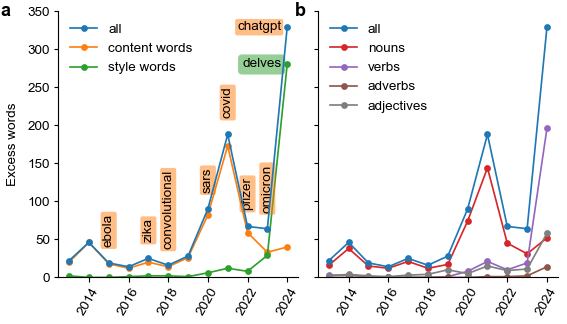

[ 22  46  19  14  25  16  28  90 188  67  64 329]
774
[  2   0   0   1   2   2   1   6  12   8  29 280]
0.6571428571428571
0.175
0.09285714285714286
0.04285714285714286


In [11]:
targetYears = np.arange(2013, 2025)

excess = np.zeros_like(targetYears)
excess_content = np.zeros_like(excess)
excess_style = np.zeros_like(excess)
excess_nouns = np.zeros_like(excess)
excess_adjectives = np.zeros_like(excess)
excess_adverbs = np.zeros_like(excess)
excess_verbs = np.zeros_like(excess)
excess_words = []
excess_words_per_year = []
excess_words_per_year_rare = []
single_words = []
single_words_style = []

for num, targetYear in enumerate(targetYears):
    subsetWords, ratios, diffs, x = compute_excess(targetYear)
    
    cutoff_ratio = 3
    if np.max(ratios[x > 1e-3]) < cutoff_ratio:
        single_words.append('')
        single_words_style.append('')
    else:
        w = words[subsetWords][x > 1e-3][np.argmax(ratios[x > 1e-3])]
        if w == 'mitogenome':
            single_words.append('')
            single_words_style.append('')
        else:
            single_words.append(w)
            single_words_style.append('')
            ind = [word2type[w] == 'non-content' for w in words[subsetWords][(x > 1e-3) & (ratios > cutoff_ratio)]]
            if np.sum(ind) > 0:
                w = words[subsetWords][(x > 1e-3) & (ratios > cutoff_ratio)][ind][np.argmax(ratios[(x > 1e-3) & (ratios > cutoff_ratio)][ind])]
                single_words_style[-1] = w
        
    ind = np.log10(ratios) > np.log10(2) - (np.log10(x) + 4) * (np.log10(2) / 4)
    ind |= diffs > 0.01
    
    excess[num] = np.sum(ind)
    excess_words += list(words[subsetWords][ind])
    excess_words_per_year.append(list(words[subsetWords][ind]))
    excess_words_per_year_rare.append(list(words[subsetWords][ind & (x < 0.01)]))
    
    excess_content[num] = np.sum([w in word2type and word2type[w] == 'content' for w in words[subsetWords][ind]])
    excess_style[num] = np.sum([w in word2type and word2type[w] == 'non-content' for w in words[subsetWords][ind]])
    excess_nouns[num] = np.sum([w in word2partofspeech and word2partofspeech[w] == 'noun' for w in words[subsetWords][ind]])
    excess_adjectives[num] = np.sum([w in word2partofspeech and word2partofspeech[w] == 'adjective' for w in words[subsetWords][ind]])
    excess_adverbs[num] = np.sum([w in word2partofspeech and word2partofspeech[w] == 'adverb' for w in words[subsetWords][ind]])
    excess_verbs[num] = np.sum([w in word2partofspeech and word2partofspeech[w] == 'verb' for w in words[subsetWords][ind]])
    
fig = plt.figure(figsize=(3.5, 2), layout='constrained')
plt.subplot(121)
plt.plot(targetYears, excess, '.-', label='all', zorder=5)
line_content = plt.plot(targetYears, excess_content, '.-', label='content words')
line_style = plt.plot(targetYears, excess_style, '.-', label='style words')
plt.ylim([0, 350])
plt.ylabel('Excess words')
plt.xticks([2014, 2016, 2018, 2020, 2022, 2024], rotation=60)
plt.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

print(excess)

for i, word in enumerate(single_words):
    if i < len(single_words) - 1:
        plt.text(targetYears[i], excess[i] + 25, word, rotation=90, ha='center',
                 bbox=dict(facecolor=line_content[0].get_color(), alpha=.5, edgecolor='none', boxstyle='round, pad=.15'))
    else:
        plt.text(targetYears[i] - .3, excess[i], word, ha='right', va='center',
                 bbox=dict(facecolor=line_content[0].get_color(), alpha=.5, edgecolor='none', boxstyle='round, pad=.15'))
        
for i, word in enumerate(single_words_style):
    plt.text(targetYears[i] - .3, excess_style[i], word, ha='right', va='center',
             bbox=dict(facecolor=line_style[0].get_color(), alpha=.5, edgecolor='none', boxstyle='round'))
    
plt.subplot(122)
plt.plot(targetYears, excess, '.-', label='all', zorder=5)
line_style = plt.plot(targetYears, excess_nouns, '.-', color='tab:red', label='nouns')
line_style = plt.plot(targetYears, excess_verbs, '.-', color='tab:purple', label='verbs')
line_style = plt.plot(targetYears, excess_adverbs, '.-', color='tab:brown', label='adverbs')
line_style = plt.plot(targetYears, excess_adjectives, '.-', color='tab:gray', label='adjectives')
plt.ylim([0, 350])
plt.gca().set_yticklabels([])
# plt.ylabel('Excess words')
plt.xticks([2014, 2016, 2018, 2020, 2022, 2024], rotation=60)
plt.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.52, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('../figures/excess-per-year.png', dpi=300)
plt.savefig('../figures/excess-per-year.pdf')

print(np.unique(excess_words).size)

print(excess_style)

print(np.mean([word2partofspeech[w] == 'verb' for w in excess_words_per_year[-1] if word2type[w] == 'non-content']))
print(np.mean([word2partofspeech[w] == 'adjective' for w in excess_words_per_year[-1] if word2type[w] == 'non-content']))
print(np.mean([word2partofspeech[w] == 'noun' for w in excess_words_per_year[-1] if word2type[w] == 'non-content']))
print(np.mean([word2partofspeech[w] == 'adverb' for w in excess_words_per_year[-1] if word2type[w] == 'non-content']))

In [12]:
# [targetYears[i] for i in range(len(targetYears)) if 'convolutional' in excess_words_per_year[i]]

In [13]:
# print([w for w in excess_words if w not in annotations.word.values])

# print([w for w in annotations.word.values if w not in excess_words])

In [14]:
# for w in list(np.unique(excess_words)):
#     print(w)

In [15]:
subsetWords, ratios, diffs, x = compute_excess(2024)

ind = np.log10(ratios) > np.log10(2) - (np.log10(x) + 4) * (np.log10(2) / 4)
ind |= diffs > 0.01
# ind &= x < 0.01

chatgpt_words =   [w         for i, w in enumerate(words[subsetWords][ind]) if word2type[w] == 'non-content']
chatgpt_words_f = [x[ind][i] for i, w in enumerate(words[subsetWords][ind]) if word2type[w] == 'non-content']

chatgpt_words = np.array(chatgpt_words)
chatgpt_words_f = np.array(chatgpt_words_f)

cutoffs = [0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

for cutoff in cutoffs:
    print(np.sum(chatgpt_words_f < cutoff))

# chatgptwords_rare = [w for w in excess_words_per_year_rare[-1] if word2type[w] == 'non-content']

# print(len(chatgptwords_rare))

# print('[')
# for lis in [chatgptwords_rare[x:x+5] for x in range(0, len(chatgptwords_rare), 5)]:
#     print("    '" + "', '".join(lis) + "',")
# print(']')

8
47
87
137
175
209
235
255
265
278
280


## Subgroup analysis

In [16]:
df_subsets = pd.read_csv('../results/yearly-counts-subgroups.csv')

for i in range(len(df_subsets)):
    f = (df_subsets.values[i, 2:2+15] + 1) / (df_subsets.values[i, 2+30:2+45] + 1)
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    delta_common = f[-1] - projection
    
    f = (df_subsets.values[i, 2+15:2+30] + 1) / (df_subsets.values[i, 2+30:2+45] + 1)
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    delta_rare = f[-1] - projection
    
    if np.all(df_subsets.values[i, 2+30:2+45][-7:-1] >= 300):
        df_subsets.loc[i, 'delta_common'] = delta_common
        df_subsets.loc[i, 'delta_rare'] = delta_rare
        df_subsets.loc[i, 'delta'] = (delta_rare + delta_common) / 2
    else:
        df_subsets.loc[i, 'delta_common'] = np.nan
        df_subsets.loc[i, 'delta_rare'] = np.nan
        df_subsets.loc[i, 'delta'] = np.nan
        
df_subsets

,grouptype,group,2010_common,2011_common,2012_common,2013_common,2014_common,2015_common,2016_common,2017_common,...,2018_total,2019_total,2020_total,2021_total,2022_total,2023_total,2024_total,delta_common,delta_rare,delta
0,all,all,150262,164542,184046,200858,218600,232093,246463,259519,...,981917,1036725,1177928,1334959,1366581,1329493,492084,0.098415,0.103051,0.100733
1,class,chemistry,5489,5744,6062,6171,6364,6278,6355,6714,...,27811,28281,29241,30228,29796,30336,13611,0.108420,0.118412,0.113416
2,class,microbiology,2496,2676,2862,2868,3217,3583,4007,4085,...,12529,13182,14262,15937,18218,15743,5048,0.040710,0.083264,0.061987
3,class,ethics,122,138,123,156,195,209,211,212,...,938,1085,1249,1059,1227,1159,338,0.017913,0.073420,0.045666
4,class,nursing,1488,1565,1638,1759,1828,1945,2029,2116,...,7551,7711,8360,9766,9734,10642,4520,0.096392,0.081156,0.088774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,journals/class,South Korea & Basel,19,19,25,34,49,70,112,150,...,864,1342,2325,3397,3217,3055,591,0.205846,0.223426,0.214636
232,journals/class,Taiwan & Frontiers,0,3,5,15,21,22,41,63,...,234,276,412,871,1109,498,85,NaN,NaN,NaN
233,journals/class,Taiwan & Basel,14,27,25,28,36,44,59,66,...,299,432,759,1349,1462,1101,184,NaN,NaN,NaN
234,journals/class,Iran & Frontiers,0,0,0,1,3,5,8,8,...,86,157,227,496,905,641,111,NaN,NaN,NaN


<IPython.core.display.Javascript object>


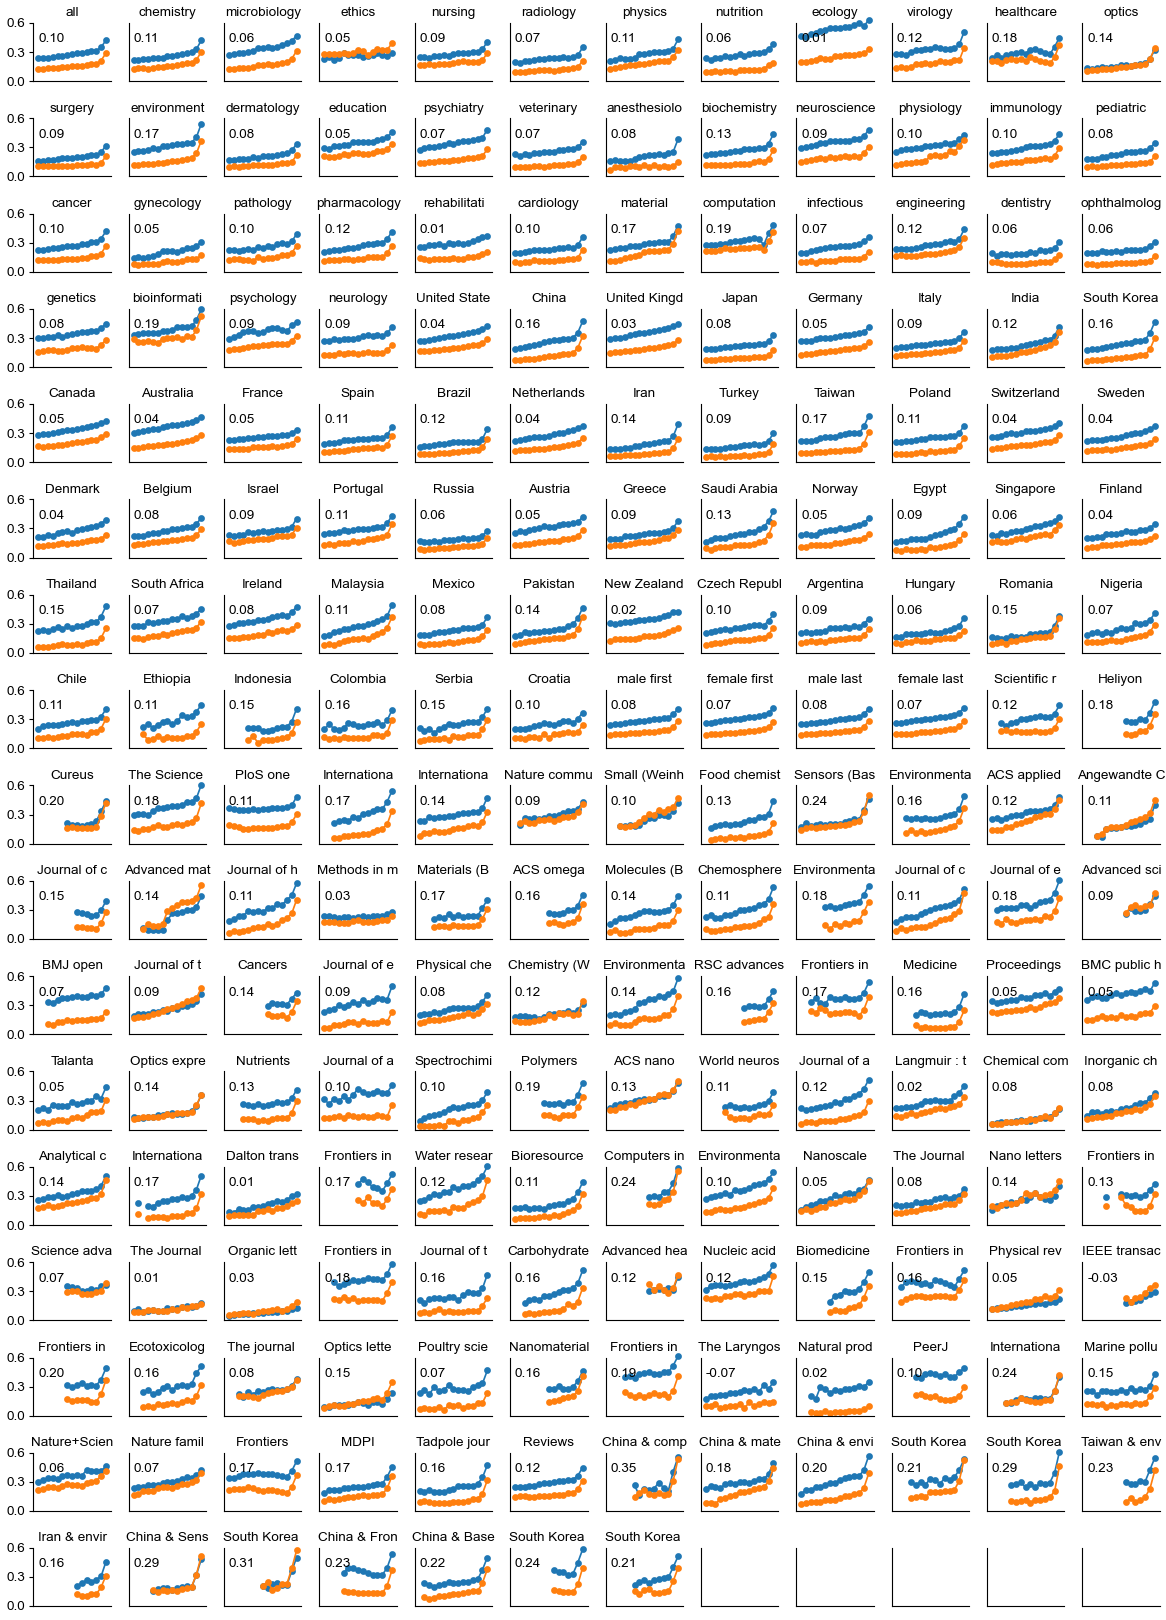

In [17]:
fig, axs = plt.subplots(nrows=17, ncols=12, figsize=(7.2, 10), layout='constrained')
num = 0

for i in range(len(df_subsets)):
    group = df_subsets.group.values[i]
    common = df_subsets.values[i, 2:2+15].ravel().astype(float)
    rare = df_subsets.values[i, 2+15:2+30].ravel().astype(float)
    total = df_subsets.values[i, 2+30:2+45].ravel().astype(float)
    
    total[:-1][total[:-1] < 300] = np.nan
    
    if np.all(~np.isnan(total[-7:-1])):
        axs.flat[num].plot(years, (common + 1) / (total + 1), '.-', clip_on=False)
        axs.flat[num].plot(years, (rare + 1) / (total + 1), '.-', clip_on=False)
        axs.flat[num].set_title(group[:12], fontsize=6)
        
        axs.flat[num].text(2010, .4, f'{df_subsets.delta.values[i]:.2f}')
        
        num += 1
        
    if num == axs.size:
        break
    
for i in range(axs.size):
    axs.flat[i].set_xticks([])
    if i % axs.shape[1]:
        axs.flat[i].set_yticks([])
    else:
        axs.flat[i].set_yticks([0, .3, .6])
    axs.flat[i].spines[['right', 'top']].set_visible(False)
    axs.flat[i].set_ylim([0, .6])
    axs.flat[i].set_xlim([2009, 2025])

<IPython.core.display.Javascript object>


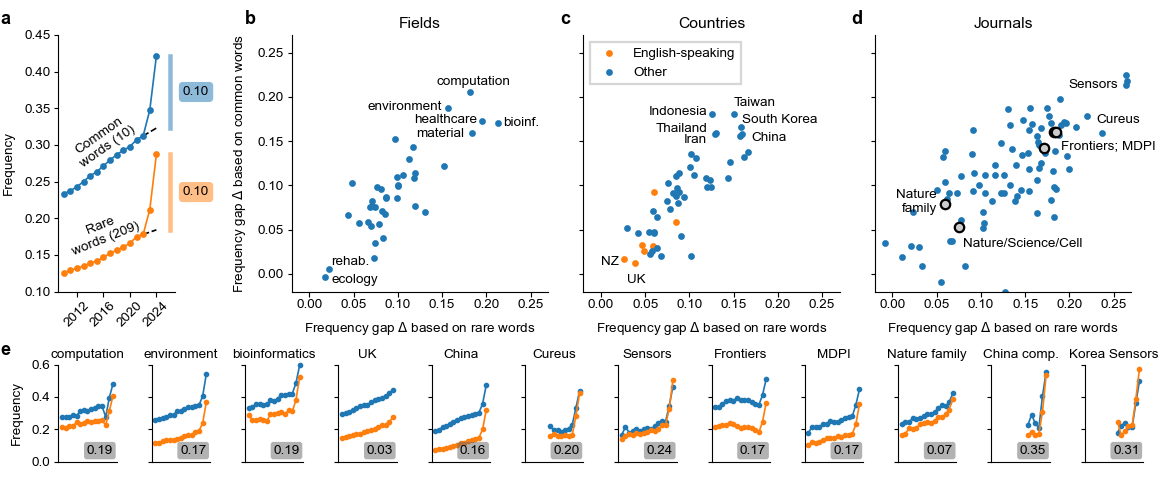

common: gap = 0.098
rare: gap = 0.103


/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:212: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword


In [18]:
fig = plt.figure(figsize=(7.2, 3))

ax = plt.axes([.05, .4, .1, .22 * 7.2 / 3])

common = df_subsets.values[0, 2:2+15].ravel().astype(float) + 1
rare = df_subsets.values[0, 2+15:2+30].ravel().astype(float) + 1
total = df_subsets.values[0, 2+30:2+45].ravel().astype(float) + 1
rare /= total
common /= total

line_common = ax.plot(years, common, '.-')
line_rare = ax.plot(years, rare, '.-')

y = common[-3] + (common[-3] - common[-4]) * np.arange(3)
ax.plot(years[-3:], y, 'k--', zorder=0)

# ax.text(2025, y[-1], f'{y[-1]:.2f}', va='center', c='#666666')
# ax.text(2025, common[-1], f'{common[-1]:.2f}', va='center', c='#666666')
ax.text(2028, (common[-1] + y[-1]) / 2, f'{common[-1] - y[-1]:.2f}', va='center',
        bbox=dict(edgecolor='none', facecolor=line_common[0].get_color(), alpha=.5, boxstyle='round'))
ax.plot([2026, 2026], [y[-1], common[-1]], lw=2, c=line_common[0].get_color(), alpha=.5)

print(f'common: gap = {common[-1] - y[-1]:.3f}')

y = rare[-3] + (rare[-3] - rare[-4]) * np.arange(3)
ax.plot(years[-3:], y, 'k--', zorder=0)

# ax.text(2025, y[-1], f'{y[-1]:.2f}', va='center', c='#666666')
# ax.text(2025, rare[-1], f'{rare[-1]:.2f}', va='center', c='#666666')
ax.text(2028, (rare[-1] + y[-1]) / 2, f'{rare[-1] - y[-1]:.2f}', va='center',
        bbox=dict(edgecolor='none', facecolor=line_rare[0].get_color(), alpha=.5, boxstyle='round'))
ax.plot([2026, 2026], [y[-1], rare[-1]], lw=2, c=line_rare[0].get_color(), alpha=.5)

print(f'rare: gap = {rare[-1] - y[-1]:.3f}')

ax.set_ylabel('Frequency')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([2012, 2016, 2020, 2024])
ax.set_xticklabels([2012, 2016, 2020, 2024], rotation=45)
ax.text(2016, 0.27, 'Common\nwords (10)', rotation=35, ha='center')
ax.text(2016, 0.15, 'Rare\nwords (209)', rotation=22, ha='center')
ax.set_ylim([0.1, 0.45])

ax = plt.axes([.25, .4, .22, .22 * 7.2 / 3])

plt.scatter(
    df_subsets[df_subsets.grouptype=='class']['delta_rare'],
    df_subsets[df_subsets.grouptype=='class']['delta_common']
)
# for i in range(len(labels)):
#     plt.text(delta_rare[i], delta_common[i] + 0.005, labels[i], fontsize=6, ha='center')
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
plt.title('Fields')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
plt.ylabel(r'Frequency gap $\Delta$ based on common words')

plt.text(0.185, 0.213, 'computation', ha='center')
plt.text(0.15, 0.185, 'environment', ha='right')
plt.text(0.175, 0.155, 'material', ha='right')
plt.text(0.19, 0.17, 'healthcare', ha='right')
plt.text(0.24, 0.167, 'bioinf.', ha='center')

plt.text(0.025, 0.01, 'rehab.')
plt.text(0.025, -0.01, 'ecology')

ax = plt.axes([.50, .4, .22, .22 * 7.2 / 3])


english = [
    'United States', 'United Kingdom', 'Canada', 'Australia', 'Ireland',
    'New Zealand', 'Nigeria'
]
other = [
    'Germany', 'Italy', 'France', 'Spain', 'Brazil', 'Netherlands',
    'Poland', 'Switzerland', 'Sweden', 'Denmark', 'Belgium',
    'Portugal', 'Russia', 'Austria', 'Greece', 'Norway',
    'South Africa', 'Mexico', 'Czech Republic', 'Argentina',
    'Romania', 'Chile', 'Colombia', 'Serbia', 'Croatia',
    'China', 'Japan', 'India', 'South Korea', 'Iran', 'Turkey', 'Taiwan', 
    'Israel', 'Saudi Arabia',  'Egypt', 'Singapore', 'Finland',
    'Thailand', 'Malaysia', 'Pakistan', 'Hungary', 'Ethiopia',
    'Indonesia'
]

assert(np.all(np.isin(df_subsets[df_subsets.grouptype=='country'].group.values, english + other)))

plt.scatter(
    df_subsets[df_subsets.group.isin(english)].delta_rare,
    df_subsets[df_subsets.group.isin(english)].delta_common,
    c = 'tab:orange', label='English-speaking'
)
plt.scatter(
    df_subsets[df_subsets.group.isin(other)].delta_rare,
    df_subsets[df_subsets.group.isin(other)].delta_common,
    c = 'tab:blue', label='Other'
)
# for gr in df_subsets[df_subsets.grouptype=='country'].group:
#     plt.text(
#         df_subsets[df_subsets.group==gr].delta_rare,
#         df_subsets[df_subsets.group==gr].delta_common,
#         gr,
#         ha='center'
#     )
plt.legend(loc='upper left', frameon=True)
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
ax.set_yticklabels([])
plt.title('Countries')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
# plt.ylabel('Based on common words')

ax.text(0.15, 0.19, 'Taiwan')
ax.text(0.16, 0.17, 'South Korea')
ax.text(0.17, 0.15, 'China')
ax.text(0.12, 0.18, 'Indonesia', ha='right')
ax.text(0.12, 0.16, 'Thailand', ha='right')
ax.text(0.12, 0.148, 'Iran', ha='right')
ax.text(0.03, -0.01, 'UK')
ax.text(0, 0.01, 'NZ')

ax = plt.axes([.75, .4, .22, .22 * 7.2 / 3])

plt.scatter(
    df_subsets[df_subsets.grouptype=='journal']['delta_rare'],
    df_subsets[df_subsets.grouptype=='journal']['delta_common'],
)
plt.scatter(
    df_subsets[df_subsets.grouptype=='journals']['delta_rare'],
    df_subsets[df_subsets.grouptype=='journals']['delta_common'],
    c = '#cccccc',
    edgecolor = 'k',
    s = 70,
)
# for gr in df_subsets[df_subsets.grouptype=='journal'].group:
#     plt.text(
#         df_subsets[df_subsets.group==gr].delta_rare,
#         df_subsets[df_subsets.group==gr].delta_common,
#         gr,
#         ha='center'
#     )
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
ax.set_yticklabels([])
plt.title('Journals')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
# ax.spines[['right', 'top']].set_visible(True)

ax.text(0.08, 0.03, 'Nature/Science/Cell', rotation=0)
ax.text(0.05, 0.07, 'Nature\nfamily', ha='right')
ax.text(0.19, 0.14, 'Frontiers; MDPI')
ax.text(0.23, 0.17, 'Cureus')
ax.text(0.255, 0.21, 'Sensors', ha='right')

# plt.ylabel('Based on common words')

subgroups = ['computation', 'environment', 'bioinformatics', 
             'United Kingdom', 'China',  
             'Cureus', 'Sensors (Basel, Switzerland)',
             'Frontiers', 'MDPI', 'Nature family', 'China & computation',
             'South Korea & Sensors (Basel, Switzerland)'
            ]
#'South Korea & environment']

shorten = {
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea',
    'Sensors (Basel, Switzerland)': 'Sensors',
    'Frontiers': 'Frontiers',
    'China & computation': 'China comp.',
    'South Korea & Sensors (Basel, Switzerland)': 'Korea Sensors'
}

for i in range(12):
    ax = plt.axes([.05 + .08 * i, .05, .05, .2])

    if i < len(subgroups):
        ind = df_subsets.group == subgroups[i]
        delta = df_subsets[ind].delta.values[0]
        common = df_subsets[ind].values[:, 2:2+15].ravel().astype(float) + 1
        rare = df_subsets[ind].values[:, 2+15:2+30].ravel().astype(float) + 1
        total = df_subsets[ind].values[:, 2+30:2+45].ravel().astype(float) + 1
        rare /= total
        common /= total
        rare[:-1][total[:-1] < 400] = np.nan
        common[:-1][total[:-1] < 400] = np.nan
        
        ax.set_title(
            shorten[subgroups[i]] if subgroups[i] in shorten else subgroups[i], 
            fontsize=6
        )
        
        ax.text(2024, 0.05, f'{delta:.2f}', ha='right',
                bbox=dict(edgecolor='none', facecolor='#666666', alpha=.5, boxstyle='round,pad=.2'))

    ax.plot(years, common, '.-', markersize=3, clip_on=False)
    ax.plot(years, rare, '.-', markersize=3)
    ax.set_xlim([2009, 2025])
    if i > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Frequency')
    ax.set_ylim([0, .6])
    ax.set_xticks([])

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.21, .95, 'b', fontsize=8, fontweight='bold')
fig.text(.48, .95, 'c', fontsize=8, fontweight='bold')
fig.text(.73, .95, 'd', fontsize=8, fontweight='bold')
fig.text(0, .27, 'e', fontsize=8, fontweight='bold')

fig.savefig('../figures/subgroups.png', dpi=300)
fig.savefig('../figures/subgroups.pdf')

<IPython.core.display.Javascript object>


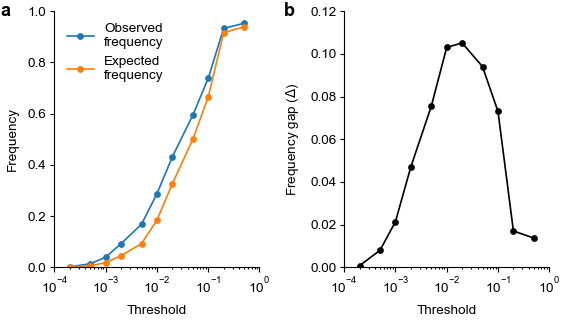

In [19]:
cutoff_counts = np.load('../results/cutoff_counts.npy')

cutoffs = [0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

cutoff_freqs = (cutoff_counts + 1) / (totals + 1)

deltas = np.zeros(len(cutoffs))
ps = np.zeros(len(cutoffs))
qs = np.zeros(len(cutoffs))

for i, f in enumerate(cutoff_freqs):
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    deltas[i] = f[-1] - projection
    ps[i] = f[-1]
    qs[i] = projection
    
fig = plt.figure(figsize=(3.5, 2), layout='constrained')
plt.subplot(121)
plt.plot(cutoffs, ps, '.-', label='Observed\nfrequency')
plt.plot(cutoffs, qs, '.-', label='Expected\nfrequency')
plt.legend()
plt.xscale('log')
plt.xlim([1e-4, 1])
plt.ylim([0, 1])
plt.ylabel('Frequency')
plt.xlabel('Threshold')

plt.subplot(122)
plt.plot(cutoffs, deltas, 'k.-', label='Frequency gap (Delta)')
# plt.legend()
plt.xscale('log')
plt.xlim([1e-4, 1])
plt.ylim([0, .12])
plt.ylabel(r'Frequency gap ($\Delta$)')
plt.xlabel('Threshold')

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.5, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('../figures/delta-curve.png', dpi=200)
plt.savefig('../figures/delta-curve.pdf')